[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/03-intermediate-pandas/intermediate-pandas.ipynb)

In [ ]:
! pip install -q pycse
from pycse.colab import pdf

# Module 03: Intermediate Pandas

Advanced data manipulation techniques for real-world data analysis.

## Learning Objectives

1. Use groupby for split-apply-combine operations
2. Merge and join DataFrames
3. Reshape data with pivot and melt
4. Apply custom functions efficiently
5. Work with datetime data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load experiments dataset
import pandas as pd

url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/experiments_intermediate.csv"
experiments = pd.read_csv(url, parse_dates=['date'])

print(f"Dataset shape: {experiments.shape}")
experiments.head()

Dataset shape: (50, 8)


,experiment_id,date,catalyst,temperature,pressure,conversion,selectivity,yield
0,EXP001,2024-01-01,Ru/Al2O3,350,4.1,0.832,0.893,74.3
1,EXP002,2024-01-02,Pt/Al2O3,300,1.3,0.859,0.808,69.4
2,EXP003,2024-01-03,Ru/Al2O3,350,2.4,0.305,0.962,29.3
3,EXP004,2024-01-04,Ru/Al2O3,500,1.5,0.632,0.739,46.7
4,EXP005,2024-01-05,Pt/Al2O3,350,4.5,0.571,0.795,45.4


```{index} groupby, split-apply-combine, aggregation
```


## GroupBy: The Split-Apply-Combine Pattern

GroupBy is arguably the most powerful Pandas operation. It lets you answer questions like:
- "What's the average yield for each catalyst?"
- "What's the best-performing temperature for each reactor?"
- "How does conversion vary by day of week?"

### The Mental Model: Split-Apply-Combine

1. **Split**: Divide data into groups based on one or more columns
2. **Apply**: Perform some operation on each group
3. **Combine**: Combine results back into a DataFrame

This is the Pandas equivalent of SQL's `GROUP BY`, but more flexible.

### When to Use GroupBy

- Comparing performance across categories (catalysts, reactors, operators)
- Aggregating replicate experiments
- Computing statistics within subgroups
- Normalizing data within groups

In [3]:
# Basic groupby: mean by catalyst
experiments.groupby('catalyst')['yield'].mean()

catalyst
Pd/Al2O3    46.633333
Pt/Al2O3    49.206667
Ru/Al2O3    52.880000
Name: yield, dtype: float64

In [4]:
# Multiple aggregations
experiments.groupby('catalyst')['yield'].agg(['mean', 'std', 'min', 'max', 'count'])

,mean,std,min,max,count
catalyst,,,,,
Pd/Al2O3,46.633333,12.843490,25.9,67.2,15
Pt/Al2O3,49.206667,15.956703,29.4,78.3,15
Ru/Al2O3,52.880000,17.198519,26.7,81.9,20


In [5]:
# Group by multiple columns
experiments.groupby(['catalyst', 'temperature'])['yield'].mean().unstack()

temperature,300,350,400,450,500
catalyst,,,,,
Pd/Al2O3,31.80,40.250000,44.466667,56.200000,46.15
Pt/Al2O3,47.84,50.766667,NaN,52.383333,32.30
Ru/Al2O3,45.30,55.540000,42.950000,50.933333,60.00


In [6]:
# Different aggregations for different columns
experiments.groupby('catalyst').agg({
    'conversion': 'mean',
    'selectivity': 'mean',
    'yield': ['mean', 'std'],
    'experiment_id': 'count'
})

conversion selectivity      yield            experiment_id
               mean        mean       mean        std         count
catalyst                                                           
Pd/Al2O3   0.575133    0.819733  46.633333  12.843490            15
Pt/Al2O3   0.578400    0.843467  49.206667  15.956703            15
Ru/Al2O3   0.625400    0.854450  52.880000  17.198519            20

In [7]:
# Named aggregations (cleaner column names)
summary = experiments.groupby('catalyst').agg(
    n_experiments=('experiment_id', 'count'),
    mean_yield=('yield', 'mean'),
    std_yield=('yield', 'std'),
    max_yield=('yield', 'max')
).round(2)

summary

,n_experiments,mean_yield,std_yield,max_yield
catalyst,,,,
Pd/Al2O3,15,46.63,12.84,67.2
Pt/Al2O3,15,49.21,15.96,78.3
Ru/Al2O3,20,52.88,17.20,81.9


In [8]:
# Custom aggregation function
def yield_range(x):
    return x.max() - x.min()

experiments.groupby('catalyst')['yield'].agg(['mean', yield_range])

,mean,yield_range
catalyst,,
Pd/Al2O3,46.633333,41.3
Pt/Al2O3,49.206667,48.9
Ru/Al2O3,52.880000,55.2


```{index} merge, join, inner join, left join, right join, outer join
```


## Merging DataFrames: Combining Data Sources

Real analysis often requires combining data from multiple sources:
- Experiment results + catalyst properties
- Sensor readings + equipment specifications
- Lab data + literature values

### The Four Types of Merges

| Type | What It Keeps | Use When |
|------|---------------|----------|
| `inner` | Only matching rows | You only want complete records |
| `left` | All rows from left table | Your main table is on the left, reference data on right |
| `right` | All rows from right table | Your main table is on the right |
| `outer` | All rows from both | You want to see what's missing |

### The Key Concept: Join Keys

The `on` parameter specifies which column(s) to match. Make sure:
- The columns have the same meaning in both tables
- Values are comparable (watch out for "Pt" vs "Pt/Al2O3")
- Missing keys are handled appropriately (check for NaN after merge)

In [9]:
# Load catalyst properties reference table
url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/catalyst_info.csv"
catalyst_info = pd.read_csv(url)
catalyst_info

,catalyst,metal_loading,surface_area,cost_per_kg
0,Pt/Al2O3,1.0,250,50000
1,Pd/Al2O3,0.5,280,30000
2,Ru/Al2O3,2.0,220,8000
3,Rh/Al2O3,0.3,300,80000


In [10]:
# Merge experiments with catalyst info
merged = experiments.merge(catalyst_info, on='catalyst', how='left')
merged.head()

,experiment_id,date,catalyst,temperature,pressure,conversion,selectivity,yield,metal_loading,surface_area,cost_per_kg
0,EXP001,2024-01-01,Ru/Al2O3,350,4.1,0.832,0.893,74.3,2.0,220,8000
1,EXP002,2024-01-02,Pt/Al2O3,300,1.3,0.859,0.808,69.4,1.0,250,50000
2,EXP003,2024-01-03,Ru/Al2O3,350,2.4,0.305,0.962,29.3,2.0,220,8000
3,EXP004,2024-01-04,Ru/Al2O3,500,1.5,0.632,0.739,46.7,2.0,220,8000
4,EXP005,2024-01-05,Pt/Al2O3,350,4.5,0.571,0.795,45.4,1.0,250,50000


In [11]:
# Different merge types
# how='left'   - Keep all rows from left DataFrame
# how='right'  - Keep all rows from right DataFrame
# how='inner'  - Keep only matching rows (intersection)
# how='outer'  - Keep all rows from both (union)

# Example: inner merge (Rh/Al2O3 exists in catalyst_info but not in experiments)
inner_merge = experiments.merge(catalyst_info, on='catalyst', how='inner')
print(f"Left: {len(experiments)}, Right: {len(catalyst_info)}, Inner: {len(inner_merge)}")

Left: 50, Right: 4, Inner: 50


```{index} pivot_table, melt, reshaping data, wide format, long format
```


## Reshaping Data: Pivot and Melt

Data comes in different "shapes," and sometimes you need to reshape it:

### Long vs Wide Format

**Long format** (tidy data):
- Each row is one observation
- Good for analysis and plotting
- Example: Each row = (catalyst, temperature, yield)

**Wide format** (spreadsheet-style):
- Columns represent different conditions
- Easier for humans to read
- Example: Rows = catalysts, Columns = temperatures, Values = yields

### When to Use Which

| Format | Use For |
|--------|---------|
| Long | Most Pandas operations, plotting, ML |
| Wide | Display tables, Excel export, certain visualizations |

### The Transformation Tools

- **`pivot_table()`**: Long → Wide (aggregate if needed)
- **`melt()`**: Wide → Long (unpivot)

In [12]:
# Pivot: long to wide format
# Create summary table: catalysts as rows, temperatures as columns
pivot_table = experiments.pivot_table(
    values='yield',
    index='catalyst',
    columns='temperature',
    aggfunc='mean'
).round(1)

pivot_table

temperature,300,350,400,450,500
catalyst,,,,,
Pd/Al2O3,31.8,40.2,44.5,56.2,46.2
Pt/Al2O3,47.8,50.8,NaN,52.4,32.3
Ru/Al2O3,45.3,55.5,43.0,50.9,60.0


In [13]:
# Multiple values in pivot
pivot_multi = experiments.pivot_table(
    values=['conversion', 'selectivity'],
    index='catalyst',
    columns='temperature',
    aggfunc='mean'
).round(2)

pivot_multi

conversion                         selectivity                    \
temperature        300   350   400   450   500         300   350   400   450   
catalyst                                                                       
Pd/Al2O3          0.45  0.44  0.59  0.68  0.61        0.70  0.90  0.76  0.84   
Pt/Al2O3          0.58  0.58   NaN  0.62  0.36        0.82  0.88   NaN  0.84   
Ru/Al2O3          0.54  0.66  0.47  0.61  0.71        0.85  0.84  0.89  0.86   

                   
temperature   500  
catalyst           
Pd/Al2O3     0.76  
Pt/Al2O3     0.90  
Ru/Al2O3     0.85

In [14]:
# Melt: wide to long format
# Useful when data is in "spreadsheet" format
wide_data = pd.DataFrame({
    'catalyst': ['Pt', 'Pd', 'Ru'],
    'yield_300K': [45, 42, 38],
    'yield_400K': [65, 62, 55],
    'yield_500K': [78, 75, 68]
})

print("Wide format:")
print(wide_data)

# Convert to long format
long_data = wide_data.melt(
    id_vars='catalyst',
    var_name='condition',
    value_name='yield'
)

print("\nLong format:")
print(long_data)

Wide format:
  catalyst  yield_300K  yield_400K  yield_500K
0       Pt          45          65          78
1       Pd          42          62          75
2       Ru          38          55          68

Long format:
  catalyst   condition  yield
0       Pt  yield_300K     45
1       Pd  yield_300K     42
2       Ru  yield_300K     38
3       Pt  yield_400K     65
4       Pd  yield_400K     62
5       Ru  yield_400K     55
6       Pt  yield_500K     78
7       Pd  yield_500K     75
8       Ru  yield_500K     68


```{index} apply, transform
```


## Apply and Transform

In [15]:
# Apply a function to each row
def categorize_yield(row):
    if row['yield'] >= 70:
        return 'high'
    elif row['yield'] >= 50:
        return 'medium'
    else:
        return 'low'

experiments['yield_category'] = experiments.apply(categorize_yield, axis=1)
experiments[['experiment_id', 'yield', 'yield_category']].head(10)

,experiment_id,yield,yield_category
0,EXP001,74.3,high
1,EXP002,69.4,medium
2,EXP003,29.3,low
3,EXP004,46.7,low
4,EXP005,45.4,low
5,EXP006,32.5,low
6,EXP007,36.3,low
7,EXP008,49.1,low
8,EXP009,70.5,high
9,EXP010,45.1,low


In [16]:
# Transform: apply function but keep original shape
# Useful for normalization within groups

# Z-score normalization of yield within each catalyst group
experiments['yield_zscore'] = experiments.groupby('catalyst')['yield'].transform(
    lambda x: (x - x.mean()) / x.std()
)

experiments[['experiment_id', 'catalyst', 'yield', 'yield_zscore']].head(10)

,experiment_id,catalyst,yield,yield_zscore
0,EXP001,Ru/Al2O3,74.3,1.245456
1,EXP002,Pt/Al2O3,69.4,1.265508
2,EXP003,Ru/Al2O3,29.3,-1.371048
3,EXP004,Ru/Al2O3,46.7,-0.359333
4,EXP005,Pt/Al2O3,45.4,-0.238562
5,EXP006,Pt/Al2O3,32.5,-1.047000
6,EXP007,Ru/Al2O3,36.3,-0.964037
7,EXP008,Pd/Al2O3,49.1,0.192056
8,EXP009,Ru/Al2O3,70.5,1.024507
9,EXP010,Ru/Al2O3,45.1,-0.452365


```{index} datetime, resample, time series
```


## Working with Dates

In [17]:
# Extract date components
experiments['year'] = experiments['date'].dt.year
experiments['month'] = experiments['date'].dt.month
experiments['week'] = experiments['date'].dt.isocalendar().week
experiments['day_of_week'] = experiments['date'].dt.day_name()

experiments[['date', 'year', 'month', 'week', 'day_of_week']].head()

,date,year,month,week,day_of_week
0,2024-01-01,2024,1,1,Monday
1,2024-01-02,2024,1,1,Tuesday
2,2024-01-03,2024,1,1,Wednesday
3,2024-01-04,2024,1,1,Thursday
4,2024-01-05,2024,1,1,Friday


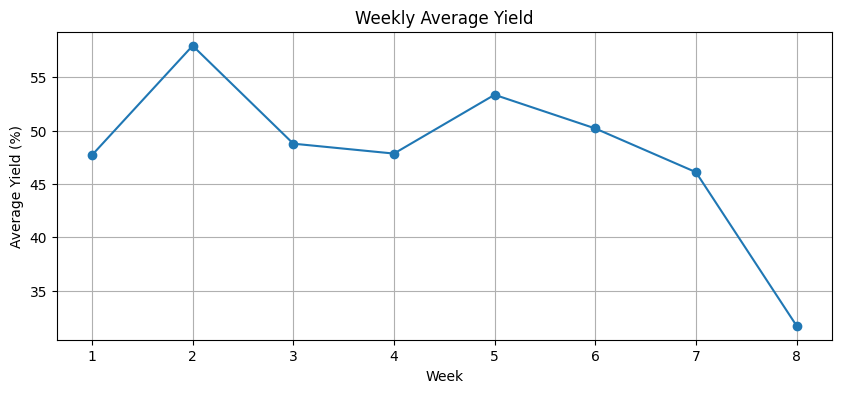

In [18]:
# Group by time period
weekly_avg = experiments.groupby('week')['yield'].mean()

plt.figure(figsize=(10, 4))
weekly_avg.plot(kind='line', marker='o')
plt.xlabel('Week')
plt.ylabel('Average Yield (%)')
plt.title('Weekly Average Yield')
plt.grid(True)
plt.show()

In [19]:
# Resample time series data
experiments_ts = experiments.set_index('date')

# Weekly average
weekly = experiments_ts['yield'].resample('W').mean()
print(weekly)

date
2024-01-07    47.700000
2024-01-14    57.957143
2024-01-21    48.771429
2024-01-28    47.842857
2024-02-04    53.357143
2024-02-11    50.200000
2024-02-18    46.100000
2024-02-25    31.700000
Freq: W-SUN, Name: yield, dtype: float64


```{index} method chaining
```


## Method Chaining

Combine operations elegantly.

In [20]:
# Instead of step-by-step:
# df1 = experiments[experiments['temperature'] >= 400]
# df2 = df1.groupby('catalyst')['yield'].mean()
# df3 = df2.sort_values(ascending=False)

# Use method chaining:
result = (
    experiments
    .query('temperature >= 400')  # Filter
    .groupby('catalyst')['yield']  # Group
    .mean()  # Aggregate
    .sort_values(ascending=False)  # Sort
    .round(1)  # Format
)

result

catalyst
Ru/Al2O3    54.4
Pd/Al2O3    50.7
Pt/Al2O3    49.5
Name: yield, dtype: float64

---

## The Catalyst Crisis: "The Outlier's Secret"

*Continued from Pandas Introduction...*

---

The data point sat alone in the upper right corner of the scatter plot, miles from its companions.

"That's got to be an error," Sam said. "Ninety-eight percent yield? The next highest is seventy-two."

Alex stared at the point. In her years at the refinery, she'd learned to be suspicious of outliers—but not in the way most people meant. Sometimes outliers were errors. Sometimes they were discoveries.

"Can we trace it back?" she asked. "Find the actual batch record?"

Maya pulled up the metadata. "Batch 7,847. March 15th. Night shift."

"The night of the thunderstorm," Frank's voice came through the speaker. He'd been sitting in on their analysis session, mostly silent. "I remember that batch. Power went out for about three minutes. Backup generators kicked in."

"And you got your best yield ever?"

Frank scratched his chin. "We assumed it was a measurement error. Wrote it off."

Alex felt a hum of excitement—the feeling she used to get when a process problem suddenly made sense. "What if it wasn't an error? What if the power outage accidentally created conditions you'd never tried on purpose?"

She pulled up the sensor data from that night. During the three-minute outage, the backup system had run the reflux pump at a higher rate—an unintended consequence of the generator switchover.

"Higher reflux ratio," Jordan said quietly. "That would change the separation efficiency."

"By a lot, apparently." Alex highlighted the data point on the plot. "This isn't an outlier to remove. It's an experiment you never meant to run."

Frank was quiet for a long moment. "We've been running this column for twelve years. Same conditions the whole time. You're telling me a thunderstorm found a better operating point?"

"I'm telling you you should test it intentionally."

After the meeting, Maya caught Alex by the coffee machine. "How did you know not to delete it?"

Alex poured herself a cup of the questionable brew. "In industry, you learn that the most important data points are usually the weirdest ones. Everyone wants to throw them out because they don't fit. But they don't fit because they're telling you something new."

She added to the mystery board: **Batch 7847: 98% yield during power outage. Higher reflux ratio. Accidental discovery—what else are we missing?**

That night, checking her Data Academy profile, she noticed a new badge had appeared: *Data Wrangler*.

She smiled. Progress.

*To be continued...*

In [21]:
# Complex analysis in one chain
analysis = (
    experiments
    .assign(yield_category=lambda df: pd.cut(df['yield'], 
                                              bins=[0, 50, 70, 100],
                                              labels=['low', 'medium', 'high']))
    .groupby(['catalyst', 'yield_category'])
    .size()
    .unstack(fill_value=0)
)

analysis

/var/folders/gq/k1kgbl7n539_4dl1md8x3jt80000gn/T/ipykernel_15657/1308025110.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['catalyst', 'yield_category'])


yield_category,low,medium,high
catalyst,,,
Pd/Al2O3,9,6,0
Pt/Al2O3,9,5,1
Ru/Al2O3,10,5,5


## Test Your Knowledge

In [22]:
! pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/03-intermediate-pandas/quizzes/intermediate-pandas-quiz.json")

/bin/bash: pip: command not found


<IPython.core.display.Javascript object>

## Recommended Reading

These resources cover advanced Pandas techniques for data transformation:

1. **[Pandas GroupBy: Your Guide to Grouping Data](https://realpython.com/pandas-groupby/)** - An in-depth tutorial on the split-apply-combine pattern with practical examples. Covers aggregation, transformation, and filtration operations.

2. **[Pandas Merging 101](https://stackoverflow.com/questions/53645882/pandas-merging-101)** - A comprehensive Stack Overflow guide covering all types of joins with clear diagrams. Bookmark this for reference when merging DataFrames.

3. **[Reshaping and Pivot Tables](https://pandas.pydata.org/docs/user_guide/reshaping.html)** - Official documentation on pivot_table, melt, stack, and unstack. Essential for transforming data between wide and long formats.

4. **[Modern Pandas (Tom Augspurger)](https://tomaugspurger.github.io/posts/modern-1-intro/)** - A blog series on writing idiomatic, efficient Pandas code. Covers method chaining, the pipe method, and performance optimization.

5. **[Effective Pandas by Matt Harrison](https://store.metasnake.com/effective-pandas-book)** - A practical guide to writing clean, efficient Pandas code. Emphasizes modern best practices and method chaining patterns.

## Summary: The Data Wrangling Toolkit

Intermediate Pandas is about transforming data to answer complex questions. Here's your toolkit:

### Core Operations

| Operation | When to Use | Key Method |
|-----------|-------------|------------|
| **GroupBy** | Compare across categories | `df.groupby('col').agg()` |
| **Merge** | Combine data sources | `df1.merge(df2, on='col')` |
| **Pivot** | Long → Wide format | `df.pivot_table()` |
| **Melt** | Wide → Long format | `df.melt()` |
| **Transform** | Apply function, keep shape | `df.groupby().transform()` |

### The Method Chaining Philosophy

Instead of:
```python
df1 = df[df['temp'] > 400]
df2 = df1.groupby('catalyst')['yield'].mean()
df3 = df2.sort_values(ascending=False)
```

Write:
```python
(df.query('temp > 400')
   .groupby('catalyst')['yield']
   .mean()
   .sort_values(ascending=False))
```

Benefits: More readable, fewer intermediate variables, easier to modify.

### Key Decisions

| Situation | Choice |
|-----------|--------|
| Need to compare groups? | Use `groupby()` |
| Need to combine tables? | Use `merge()` with appropriate `how=` |
| Need to aggregate duplicates? | Use `pivot_table(aggfunc=...)` |
| Need to normalize within groups? | Use `groupby().transform()` |

### Common Gotchas

- `groupby()` returns a GroupBy object, not a DataFrame—add `.mean()`, `.agg()`, etc.
- `merge()` may create more rows than expected if keys aren't unique
- `pivot_table()` aggregates by default (use `aggfunc` to control how)
- Watch for column names becoming tuples after complex aggregations

## Next Steps

Now that you can manipulate data effectively, we'll move to dimensionality reduction—techniques for exploring and visualizing high-dimensional datasets before building models.